# Bottlenecks: How Capacity Limits Determine Overall Performance

This notebook demonstrates **bottlenecks** - points in networks where capacity limits determine overall flow.

Understanding bottlenecks is essential because:
- **Bottlenecks determine maximum flow** - the bottleneck with lowest capacity limits everything
- **Improving non-bottlenecks doesn't help** - only improving bottlenecks increases overall performance
- **Average capacity is misleading** - minimum capacity (the bottleneck) determines flow
- **Identifying bottlenecks** helps you prioritize capacity investments effectively


## Key Concepts

**Bottleneck** is a point where capacity limits flow:
- Can be a node (warehouse, server, processing facility) or a link (road, pipeline, connection)
- The bottleneck has the lowest capacity relative to flow
- The bottleneck determines the maximum flow through the entire network

**Why Bottlenecks Matter**:
- Even if most of the network has plenty of capacity, flow is limited by the bottleneck
- Improving capacity elsewhere doesn't help - only improving the bottleneck increases flow
- The bottleneck is like the narrowest part of a funnel - it limits everything

**Average vs Minimum Capacity**:
- **Average capacity** across the network does NOT determine maximum flow
- **Minimum capacity** (the bottleneck) determines maximum flow
- Focusing on average capacity leads to incorrect capacity planning

**Critical insight**: Identifying and addressing bottlenecks is the key to improving network performance. Investing in non-bottlenecks wastes resources.


## Scenario: Port Logistics Network

A port handles container ships. Containers flow through multiple stages: ships dock, cranes unload, containers are stored, and trucks transport them away.

**The Network Stages**:
- Docks: Can handle 10 ships at a time
- Cranes: Can unload 100 containers per hour
- Storage: Can hold 1,000 containers
- Trucks: Can transport 200 containers per hour

**The Challenge**:
- Each stage has different capacity
- The bottleneck (lowest capacity) limits overall throughput
- Ships are experiencing delays - where is the bottleneck?

**The Question**: Which stage is the bottleneck? How does it limit overall port performance?


## Step 1: Install Required Packages (Colab)


In [1]:
%pip install matplotlib numpy pandas -q



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10


## Step 3: Define Port Network Stages and Capacities

Let's model the port as a network with different capacity stages:


In [3]:
# Port network stages with capacities
stages = {
    'Docks': {'capacity': 10, 'unit': 'ships'},
    'Cranes': {'capacity': 100, 'unit': 'containers/hour'},
    'Storage': {'capacity': 1000, 'unit': 'containers'},
    'Trucks': {'capacity': 200, 'unit': 'containers/hour'}
}

# Convert all to common unit: containers per hour
# Assumptions: 1 ship = 50 containers, dock time = 1 hour, storage is instantaneous
conversion_factors = {
    'Docks': 10 * 50 / 1,  # 10 ships * 50 containers / 1 hour = 500 containers/hour
    'Cranes': 100,  # Already in containers/hour
    'Storage': 1000 / 1,  # 1000 containers can be processed in 1 hour = 1000 containers/hour
    'Trucks': 200  # Already in containers/hour
}

# Calculate effective capacity in containers/hour
stage_data = []
for stage, info in stages.items():
    effective_capacity = conversion_factors[stage]
    stage_data.append({
        'Stage': stage,
        'Capacity': info['capacity'],
        'Unit': info['unit'],
        'Effective_Capacity_containers_per_hour': effective_capacity
    })

port_df = pd.DataFrame(stage_data)
print("PORT NETWORK STAGES:")
print("=" * 70)
display(port_df)

# Find bottleneck (minimum effective capacity)
bottleneck_stage = port_df.loc[port_df['Effective_Capacity_containers_per_hour'].idxmin(), 'Stage']
bottleneck_capacity = port_df.loc[port_df['Effective_Capacity_containers_per_hour'].idxmin(), 'Effective_Capacity_containers_per_hour']

print(f"\n🔍 BOTTLENECK IDENTIFIED:")
print(f"   Stage: {bottleneck_stage}")
print(f"   Effective Capacity: {bottleneck_capacity:.0f} containers/hour")
print(f"   This limits overall port throughput!")


PORT NETWORK STAGES:


,Stage,Capacity,Unit,Effective_Capacity_containers_per_hour
0,Docks,10,ships,500.0
1,Cranes,100,containers/hour,100.0
2,Storage,1000,containers,1000.0
3,Trucks,200,containers/hour,200.0



🔍 BOTTLENECK IDENTIFIED:
   Stage: Cranes
   Effective Capacity: 100 containers/hour
   This limits overall port throughput!


## Step 4: Visualize Bottleneck Impact

The bottleneck determines maximum flow. Let's visualize this:


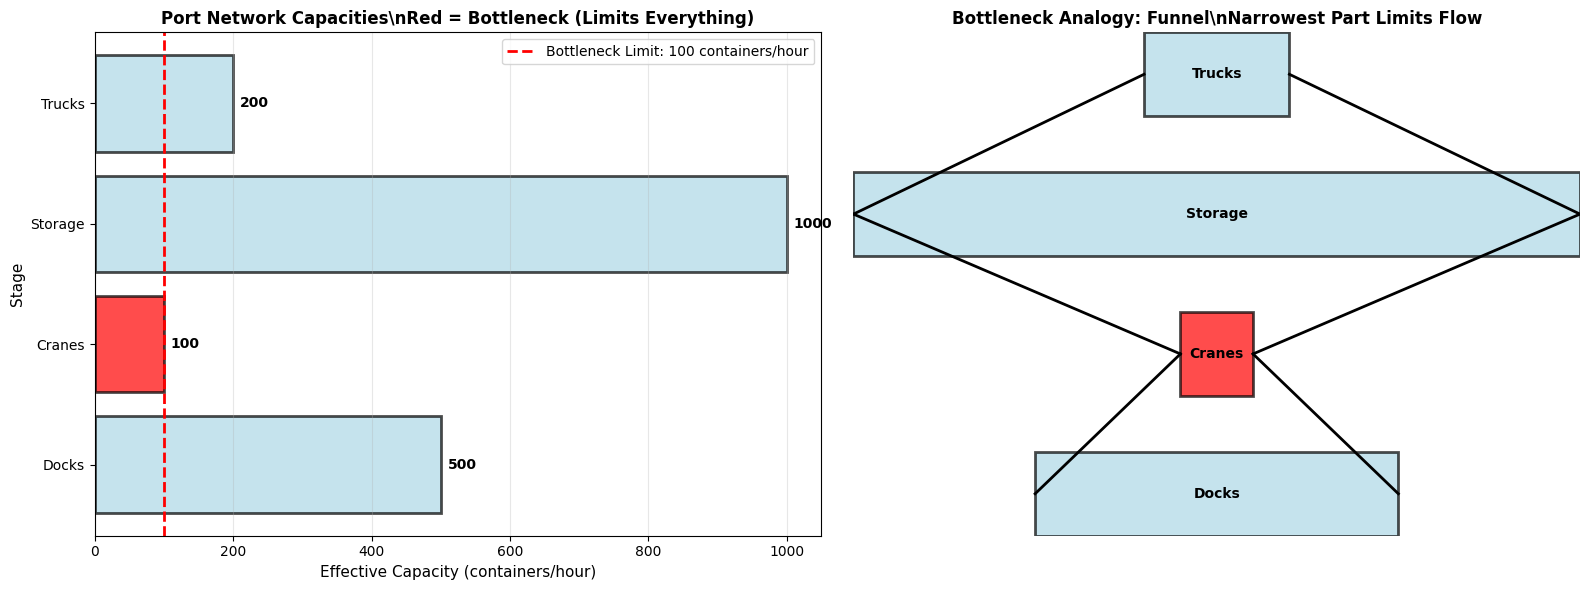

\nKey Insight:
  • Cranes is the bottleneck with capacity 100 containers/hour
  • Even though other stages have higher capacity, the bottleneck limits everything
  • Maximum port throughput = 100 containers/hour
  • Improving other stages won't help until the bottleneck is addressed


In [4]:
# Visualize capacities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Capacity by Stage
stages_list = port_df['Stage'].values
capacities = port_df['Effective_Capacity_containers_per_hour'].values
colors = ['red' if stage == bottleneck_stage else 'lightblue' for stage in stages_list]

bars1 = ax1.barh(stages_list, capacities, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.axvline(x=bottleneck_capacity, color='red', linestyle='--', linewidth=2, 
           label=f'Bottleneck Limit: {bottleneck_capacity:.0f} containers/hour')
ax1.set_xlabel('Effective Capacity (containers/hour)', fontsize=11)
ax1.set_ylabel('Stage', fontsize=11)
ax1.set_title('Port Network Capacities\\nRed = Bottleneck (Limits Everything)', fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, cap) in enumerate(zip(bars1, capacities)):
    ax1.text(cap + 10, i, f'{cap:.0f}', va='center', fontweight='bold')

# Plot 2: Funnel Analogy
funnel_stages = ['Docks', 'Cranes', 'Storage', 'Trucks']
funnel_widths = [cap / max(capacities) * 100 for cap in capacities]  # Normalize to percentage

y_positions = np.linspace(0, 100, len(funnel_stages))
colors_funnel = ['red' if stage == bottleneck_stage else 'lightblue' for stage in funnel_stages]

for i, (stage, width, y_pos, color) in enumerate(zip(funnel_stages, funnel_widths, y_positions, colors_funnel)):
    # Draw funnel segment
    if i == 0:
        x_left = 50 - width/2
        x_right = 50 + width/2
    else:
        prev_width = funnel_widths[i-1]
        x_left = 50 - width/2
        x_right = 50 + width/2
        # Draw connecting lines
        prev_y = y_positions[i-1]
        ax2.plot([50 - prev_width/2, x_left], [prev_y, y_pos], 'k-', linewidth=2)
        ax2.plot([50 + prev_width/2, x_right], [prev_y, y_pos], 'k-', linewidth=2)
    
    # Draw rectangle for this stage
    rect_height = 20
    rect = plt.Rectangle((x_left, y_pos - rect_height/2), width, rect_height, 
                        facecolor=color, edgecolor='black', linewidth=2, alpha=0.7)
    ax2.add_patch(rect)
    ax2.text(50, y_pos, stage, ha='center', va='center', fontweight='bold', fontsize=10)

ax2.set_xlim(0, 100)
ax2.set_ylim(-10, 110)
ax2.set_title('Bottleneck Analogy: Funnel\\nNarrowest Part Limits Flow', fontweight='bold', fontsize=12)
ax2.axis('off')

plt.tight_layout()
plt.show()

print(f"\\nKey Insight:")
print(f"  • {bottleneck_stage} is the bottleneck with capacity {bottleneck_capacity:.0f} containers/hour")
print(f"  • Even though other stages have higher capacity, the bottleneck limits everything")
print(f"  • Maximum port throughput = {bottleneck_capacity:.0f} containers/hour")
print(f"  • Improving other stages won't help until the bottleneck is addressed")


SCENARIO: Improve Non-Bottleneck Stages
\nCapacity Improvements (Non-Bottleneck Stages +50%):


,Stage,Original_Capacity,Improved_Capacity,Change,Change_%,Is_Bottleneck
0,Docks,500.0,750.0,250.0,50.0,False
1,Cranes,100.0,100.0,0.0,0.0,True
2,Storage,1000.0,1500.0,500.0,50.0,False
3,Trucks,200.0,300.0,100.0,50.0,False


\n📊 RESULTS:
   Original Maximum Flow: 100 containers/hour
   Improved Maximum Flow: 100 containers/hour
   Change: 0 containers/hour (0.0%)
\n   ⚠️  NO IMPROVEMENT! The bottleneck still limits flow.
   Improving non-bottleneck stages wasted resources.


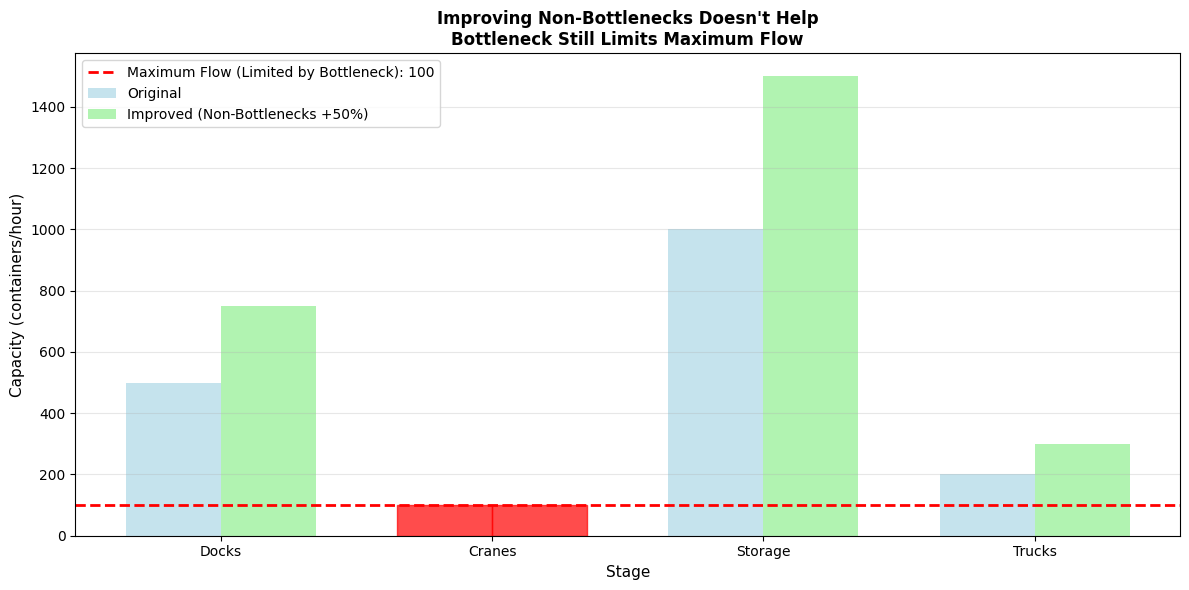

\nKey Insight:
  • Improving non-bottleneck stages doesn't increase maximum flow
  • Only improving the bottleneck increases overall performance
  • This is why identifying bottlenecks is critical


In [5]:
# Scenario: Improve non-bottleneck stages
print("SCENARIO: Improve Non-Bottleneck Stages")
print("=" * 70)

# Original capacities
original_capacities = port_df['Effective_Capacity_containers_per_hour'].values.copy()
max_flow_original = min(original_capacities)

# Improve non-bottleneck stages by 50%
improved_capacities = original_capacities.copy()
for i, stage in enumerate(stages_list):
    if stage != bottleneck_stage:
        improved_capacities[i] = original_capacities[i] * 1.5  # 50% increase

max_flow_improved = min(improved_capacities)

# Create comparison
comparison_data = {
    'Stage': stages_list,
    'Original_Capacity': original_capacities,
    'Improved_Capacity': improved_capacities,
    'Change': improved_capacities - original_capacities,
    'Change_%': ((improved_capacities - original_capacities) / original_capacities * 100)
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Is_Bottleneck'] = comparison_df['Stage'] == bottleneck_stage

print("\\nCapacity Improvements (Non-Bottleneck Stages +50%):")
display(comparison_df.round(1))

print(f"\\n📊 RESULTS:")
print(f"   Original Maximum Flow: {max_flow_original:.0f} containers/hour")
print(f"   Improved Maximum Flow: {max_flow_improved:.0f} containers/hour")
print(f"   Change: {max_flow_improved - max_flow_original:.0f} containers/hour ({((max_flow_improved - max_flow_original)/max_flow_original*100):.1f}%)")

if max_flow_improved == max_flow_original:
    print(f"\\n   ⚠️  NO IMPROVEMENT! The bottleneck still limits flow.")
    print(f"   Improving non-bottleneck stages wasted resources.")
else:
    print(f"\\n   ✓ Some improvement, but bottleneck still limits.")

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(stages_list))
width = 0.35

bars1 = ax.bar(x - width/2, original_capacities, width, label='Original', color='lightblue', alpha=0.7)
bars2 = ax.bar(x + width/2, improved_capacities, width, label='Improved (Non-Bottlenecks +50%)', color='lightgreen', alpha=0.7)

# Highlight bottleneck
bottleneck_idx = list(stages_list).index(bottleneck_stage)
bars1[bottleneck_idx].set_color('red')
bars2[bottleneck_idx].set_color('red')

# Draw maximum flow line
ax.axhline(y=max_flow_original, color='red', linestyle='--', linewidth=2, 
          label=f'Maximum Flow (Limited by Bottleneck): {max_flow_original:.0f}')

ax.set_xlabel('Stage', fontsize=11)
ax.set_ylabel('Capacity (containers/hour)', fontsize=11)
ax.set_title('Improving Non-Bottlenecks Doesn\'t Help\nBottleneck Still Limits Maximum Flow', 
            fontweight='bold', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(stages_list)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\\nKey Insight:")
print("  • Improving non-bottleneck stages doesn't increase maximum flow")
print("  • Only improving the bottleneck increases overall performance")
print("  • This is why identifying bottlenecks is critical")


AVERAGE CAPACITY vs MINIMUM CAPACITY
Average Capacity: 450 containers/hour
Minimum Capacity (Bottleneck): 100 containers/hour
\nMaximum Flow = 100 containers/hour (limited by bottleneck)
\n✗ WRONG: Using average capacity (450) would overestimate flow
✓ CORRECT: Using minimum capacity (100) gives actual maximum flow


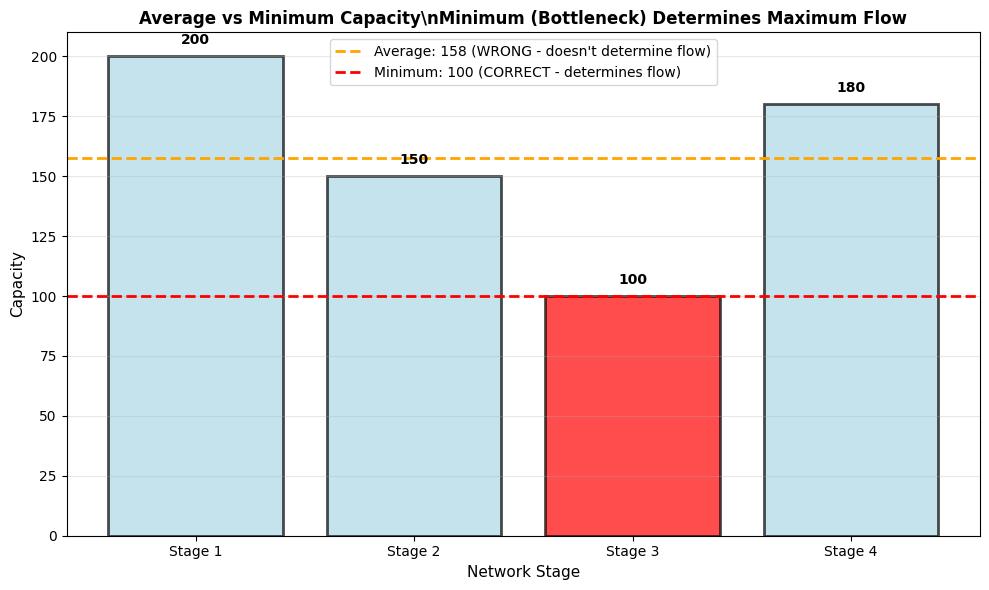

\nKey Insight:
  • Average capacity is misleading - it doesn't determine maximum flow
  • Minimum capacity (the bottleneck) determines maximum flow
  • Focusing on average leads to incorrect capacity planning
  • Always identify the minimum capacity point


In [6]:
# Calculate average vs minimum
average_capacity = np.mean(original_capacities)
minimum_capacity = np.min(original_capacities)

print("AVERAGE CAPACITY vs MINIMUM CAPACITY")
print("=" * 70)
print(f"Average Capacity: {average_capacity:.0f} containers/hour")
print(f"Minimum Capacity (Bottleneck): {minimum_capacity:.0f} containers/hour")
print(f"\\nMaximum Flow = {minimum_capacity:.0f} containers/hour (limited by bottleneck)")
print(f"\\n✗ WRONG: Using average capacity ({average_capacity:.0f}) would overestimate flow")
print(f"✓ CORRECT: Using minimum capacity ({minimum_capacity:.0f}) gives actual maximum flow")

# Visualize the pitfall
fig, ax = plt.subplots(figsize=(10, 6))

# Create a simple network path
path_stages = ['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4']
path_capacities = [200, 150, 100, 180]  # Stage 3 is bottleneck

x_positions = np.arange(len(path_stages))
colors_path = ['red' if cap == min(path_capacities) else 'lightblue' for cap in path_capacities]

bars = ax.bar(x_positions, path_capacities, color=colors_path, alpha=0.7, edgecolor='black', linewidth=2)

# Draw average and minimum lines
avg_cap = np.mean(path_capacities)
min_cap = min(path_capacities)

ax.axhline(y=avg_cap, color='orange', linestyle='--', linewidth=2, 
                      label=f'Average: {avg_cap:.0f} (WRONG - doesn\'t determine flow)')
ax.axhline(y=min_cap, color='red', linestyle='--', linewidth=2, 
          label=f'Minimum: {min_cap:.0f} (CORRECT - determines flow)')

ax.set_xlabel('Network Stage', fontsize=11)
ax.set_ylabel('Capacity', fontsize=11)
ax.set_title('Average vs Minimum Capacity\\nMinimum (Bottleneck) Determines Maximum Flow', 
            fontweight='bold', fontsize=12)
ax.set_xticks(x_positions)
ax.set_xticklabels(path_stages)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, cap) in enumerate(zip(bars, path_capacities)):
    ax.text(i, cap + 5, f'{cap}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\\nKey Insight:")
print("  • Average capacity is misleading - it doesn't determine maximum flow")
print("  • Minimum capacity (the bottleneck) determines maximum flow")
print("  • Focusing on average leads to incorrect capacity planning")
print("  • Always identify the minimum capacity point")


## Step 7: Key Takeaways

**Bottlenecks determine maximum flow**:
- The bottleneck (minimum capacity point) limits overall network performance
- Even if most of the network has excess capacity, the bottleneck limits everything

**Improving non-bottlenecks doesn't help**:
- Only improving the bottleneck increases overall flow
- Investing in non-bottlenecks wastes resources

**Average vs minimum capacity**:
- Average capacity does NOT determine maximum flow
- Minimum capacity (the bottleneck) determines maximum flow
- Focusing on average leads to incorrect planning

**Identifying bottlenecks is critical**:
- Compare capacity at every point in the network
- The point with lowest capacity relative to flow is the bottleneck
- Focus investments on bottlenecks, not averages

**Next steps**: Once you understand bottlenecks, you can think about tradeoffs between different objectives (cost, speed, reliability) in network decisions.
